In [1]:
#%pip install numpy pandas matplotlib scikit-learn tensorflow seaborn


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# --- 1. Data Loading and Initial Inspection ---

csv_file_path_1 = "../../data/dev101_prepared.csv"
csv_file_path_2 = "../../data/dev102_prepared.csv"
csv_file_path_3 = "../../data/devAll_prepared.csv"

try:
    df1 = pd.read_csv(csv_file_path_1)
    df2 = pd.read_csv(csv_file_path_2)
except FileNotFoundError as e:
    print(f"Error: One or more CSV files not found. Please check the paths.")
    print(f"Details: {e}")
    exit() 

#df_all = pd.concat([df1, df2], ignore_index=True)
df_all = pd.read_csv(csv_file_path_3)

print("--- Initial Data Description ---")
df_all.describe()


--- Initial Data Description ---


,devID,soil,rain,temp,humi,geo,unixt,lat,lng,rain_1h_sum,...,soil_1d_mean,geo_1h_mean,geo_3h_mean,geo_6h_mean,geo_12h_mean,geo_1d_mean,soil_diff,geo_diff,soil_1h_std,geo_1h_std
count,177234.000000,177234.000000,177234.000000,177234.000000,177234.000000,177234.000000,1.772340e+05,177234.000000,177234.000000,177234.000000,...,177234.000000,177234.000000,177234.000000,177234.000000,177234.000000,177234.000000,177234.000000,177234.000000,177234.000000,177234.000000
mean,101.517705,52.436798,0.321512,29.730532,75.817045,8.301646,1.747941e+09,8.637961,99.893907,91.937595,...,51.467161,8.313153,8.341103,8.357829,8.417408,8.469708,0.000136,0.000005,0.272874,4.885763
std,0.499688,8.578281,2.254735,3.044661,7.885193,6.813995,1.323248e+06,0.105788,0.708252,523.591766,...,9.148900,4.029482,3.937026,3.910837,3.878479,3.851458,0.280174,7.091224,0.787130,2.589536
min,101.000000,0.000000,0.000000,23.817043,49.191883,0.000000,1.746186e+09,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-57.799999,-31.979723,0.000000,0.000000
25%,101.000000,47.900002,0.000000,27.392616,70.365677,3.592406,1.746474e+09,8.637946,99.898933,0.000000,...,48.326881,4.408757,4.570118,4.790465,4.929546,4.911355,0.000000,-1.245422,0.070097,3.037493
50%,102.000000,53.299999,0.000000,28.327232,79.395210,4.508679,1.748607e+09,8.637970,99.898949,0.000000,...,52.254509,8.004702,7.936313,7.786258,7.735992,7.721577,0.000000,0.000000,0.107738,4.931288
75%,102.000000,58.599998,0.000000,32.324711,81.212944,13.010499,1.749047e+09,8.638007,99.898972,0.000000,...,57.888089,11.343072,11.440695,11.489187,11.668052,11.297946,0.000000,1.232060,0.215091,6.513450
max,102.000000,65.599998,41.630600,38.984512,88.510567,32.062466,1.749750e+09,48.859433,99.899544,7691.881943,...,63.668290,31.989561,31.989561,31.989561,31.989561,31.989561,57.799999,31.505789,12.815212,12.330683


In [4]:
# --- 2. Feature Column Validation and Data Preparation ---
feature_cols = [
    'timestamp', 'soil', 'rain', 'temp', 'humi', 'geo', 'lat', 'lng'
]

missing = [col for col in feature_cols if col not in df_all.columns]
if missing:
    raise ValueError(f"Missing columns in the combined data: {missing}. Please ensure your CSV files contain these columns.")
else:
    print("All required feature columns are present.")

df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
df_all = df_all.sort_values('timestamp').reset_index(drop=True)

numerical_feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo', 'lat', 'lng']
data_for_model = df_all[numerical_feature_cols].values

print(f"Shape of numerical data prepared for model: {data_for_model.shape}\n")


All required feature columns are present.
Shape of numerical data prepared for model: (177234, 7)



In [5]:
# --- 3. Data Splitting (Training, Validation, Test Sets) ---

train_ratio = 0.8  
val_test_ratio = 1 - train_ratio 

X_train_raw, X_temp_raw = train_test_split(data_for_model, test_size=val_test_ratio, shuffle=False)

val_ratio_of_temp = 0.5
X_val_raw, X_test_raw = train_test_split(X_temp_raw, test_size=val_ratio_of_temp, shuffle=False)

print(f"Shape of raw training data: {X_train_raw.shape}")
print(f"Shape of raw validation data: {X_val_raw.shape}")
print(f"Shape of raw test data: {X_test_raw.shape}\n")

Shape of raw training data: (141787, 7)
Shape of raw validation data: (17723, 7)
Shape of raw test data: (17724, 7)



In [6]:
# --- 4. Data Scaling ---
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train_raw)
scaled_X_val = scaler.transform(X_val_raw)
scaled_X_test = scaler.transform(X_test_raw)

print(f"Shape of scaled training data: {scaled_X_train.shape}")
print(f"Shape of scaled validation data: {scaled_X_val.shape}")
print(f"Shape of scaled test data: {scaled_X_test.shape}\n")


Shape of scaled training data: (141787, 7)
Shape of scaled validation data: (17723, 7)
Shape of scaled test data: (17724, 7)



In [7]:
# --- 5. Sequence Creation for LSTM ---

def create_sequences(data, sequence_length):
    xs = []
    for i in range(len(data) - sequence_length + 1):
        xs.append(data[i:(i + sequence_length)])
    return np.array(xs)

SEQUENCE_LENGTH = 30

X_train_seq = create_sequences(scaled_X_train, SEQUENCE_LENGTH)
X_val_seq = create_sequences(scaled_X_val, SEQUENCE_LENGTH)
X_test_seq = create_sequences(scaled_X_test, SEQUENCE_LENGTH)

print(f"Shape of training sequences: {X_train_seq.shape}")
print(f"Shape of validation sequences: {X_val_seq.shape}")
print(f"Shape of test sequences: {X_test_seq.shape}\n")

Shape of training sequences: (141758, 30, 7)
Shape of validation sequences: (17694, 30, 7)
Shape of test sequences: (17695, 30, 7)



In [8]:
# --- 6. Building the LSTM Autoencoder Model ---

n_features = scaled_X_train.shape[1]
input_shape = (SEQUENCE_LENGTH, n_features) 

encoder_inputs = Input(shape=input_shape)
encoder_lstm = LSTM(units=32, activation='relu', return_sequences=False)(encoder_inputs) 

decoder_inputs = RepeatVector(SEQUENCE_LENGTH)(encoder_lstm)

decoder_lstm = LSTM(units=32, activation='relu', return_sequences=True)(decoder_inputs)

decoder_outputs = TimeDistributed(Dense(n_features))(decoder_lstm)

model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

print("--- LSTM Autoencoder Model Summary ---")
model.summary()
print("\n")


--- LSTM Autoencoder Model Summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 7)          │           231 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,671 (53.40 KB)

 Trainable params: 13,671 (53.40 KB)

 Non-trainable params: 0 (0.00 B)

--- Starting Model Training ---
Epoch 1/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 0.0267 - val_loss: 0.0053
Epoch 2/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 3/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 0.0063 - val_loss: 0.0044
Epoch 4/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 5/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 6/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 7/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 8/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 9/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 10/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 11/50
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 0.0038 - val_

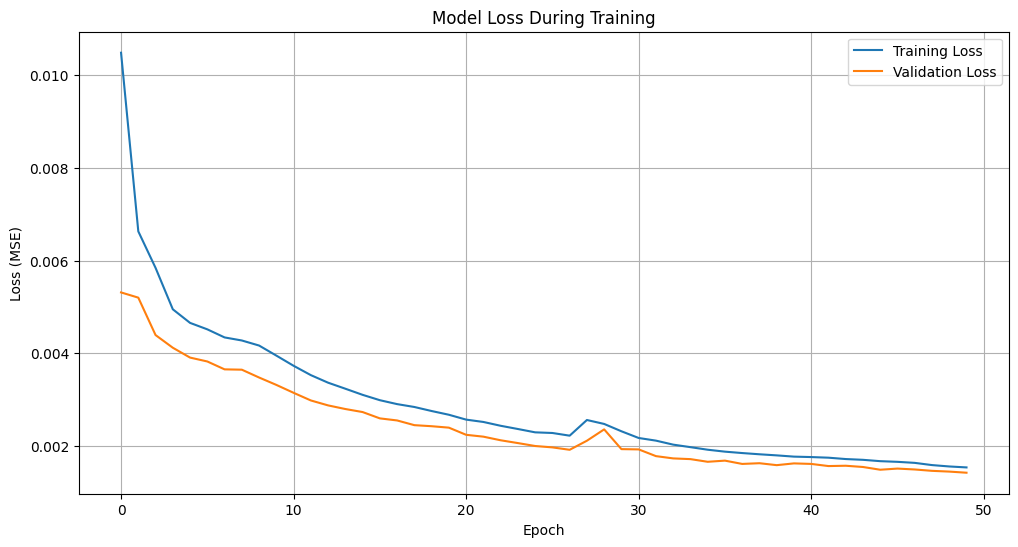

In [9]:
# --- 7. Training the Model ---

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

print("--- Starting Model Training ---")
history = model.fit(
    X_train_seq, X_train_seq, 
    epochs=50, 
    batch_size=32,
    validation_data=(X_val_seq, X_val_seq), 
    callbacks=[early_stopping], 
    verbose=1 
)

print("--- Model Training Complete ---\n")

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


--- Performing Predictions on Test Data for Anomaly Detection ---
553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step

Calculated Anomaly Threshold (from training data MSE): 0.006175
Number of detected anomalies in the test set: 22


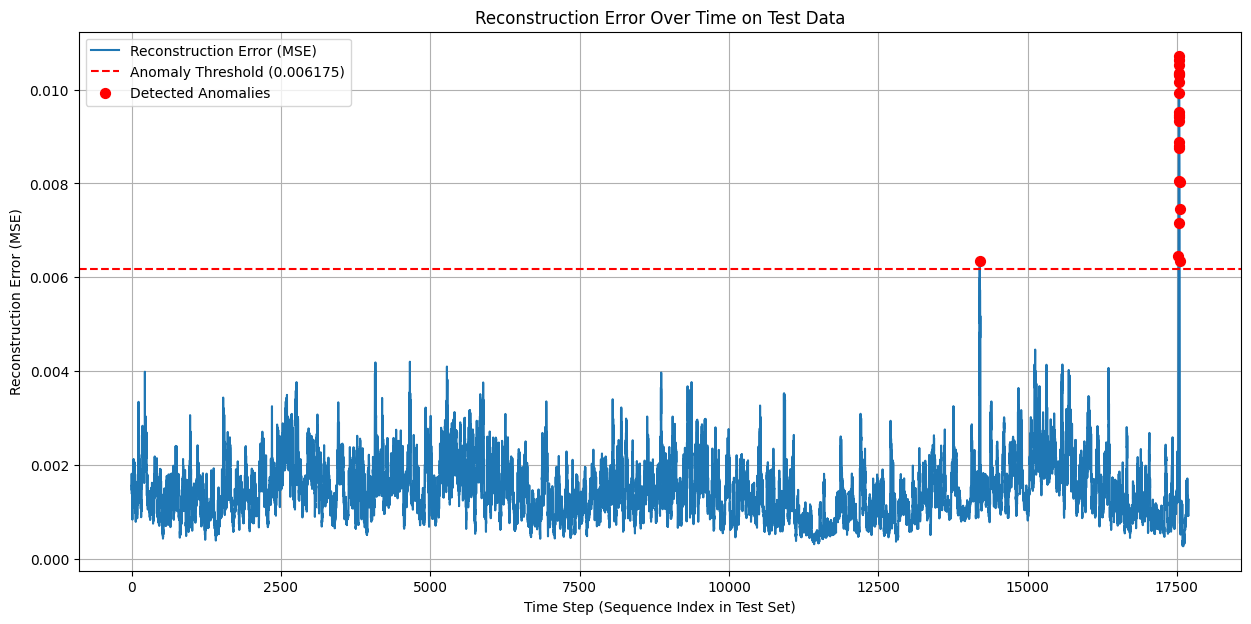

In [10]:
# --- 8. Anomaly Detection ---

print("--- Performing Predictions on Test Data for Anomaly Detection ---")
X_pred_seq = model.predict(X_test_seq)

mse = np.mean(np.power(X_test_seq - X_pred_seq, 2), axis=(1, 2))


plt.figure(figsize=(15, 7))
plt.plot(mse, label='Reconstruction Error (MSE)')
plt.title('Reconstruction Error Over Time on Test Data')
plt.xlabel('Time Step (Sequence Index in Test Set)')
plt.ylabel('Reconstruction Error (MSE)')

# --- Determine Anomaly Threshold ---
X_train_pred_seq = model.predict(X_train_seq)
train_mse = np.mean(np.power(X_train_seq - X_train_pred_seq, 2), axis=(1, 2))

# Calculate the threshold
threshold = np.mean(train_mse) + 3 * np.std(train_mse)
anomalies = mse > threshold
anomaly_indices = np.where(anomalies)[0]

print(f"\nCalculated Anomaly Threshold (from training data MSE): {threshold:.6f}")
print(f"Number of detected anomalies in the test set: {len(anomaly_indices)}")

plt.axhline(y=threshold, color='r', linestyle='--', label=f'Anomaly Threshold ({threshold:.6f})')
plt.scatter(anomaly_indices, mse[anomaly_indices], color='red', s=50, zorder=5, label='Detected Anomalies')
plt.legend()
plt.grid(True)
plt.show()


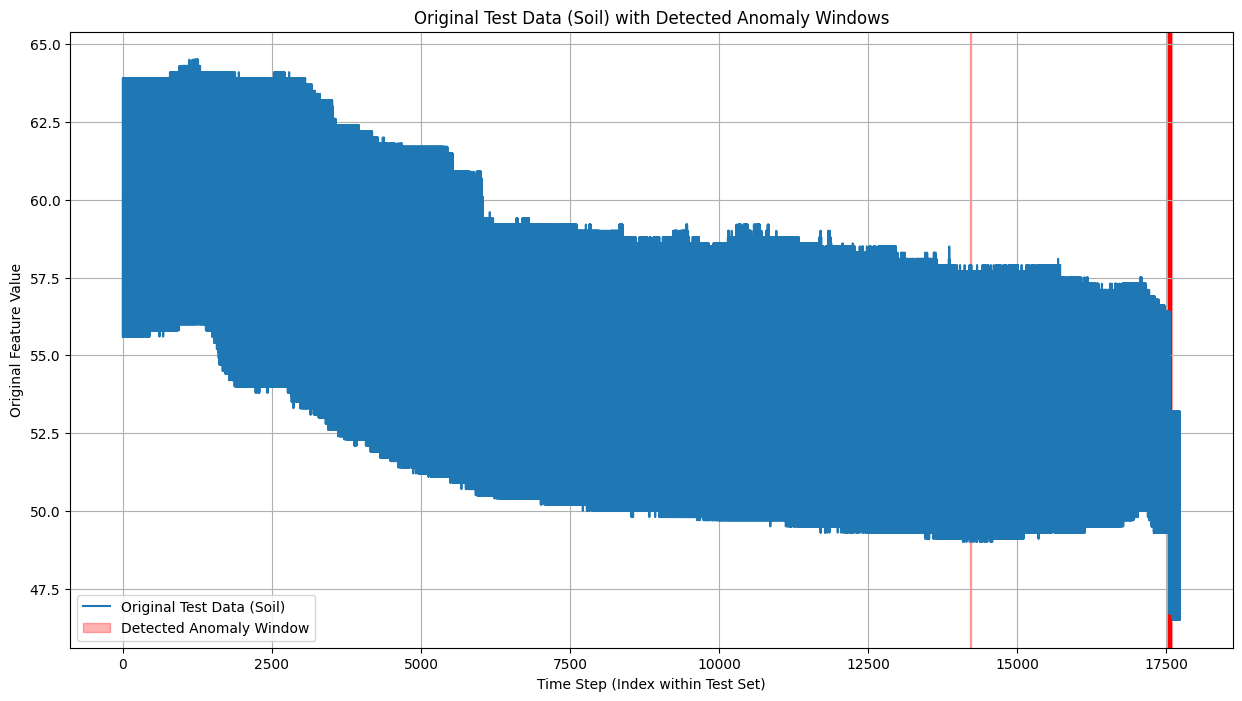


--- Anomaly Detection Process Complete ---


In [11]:
# --- 9. Visualize Detected Anomalies on Original Data ---


plt.figure(figsize=(15, 8))
plt.plot(X_test_raw[:, 0], label='Original Test Data (Soil)')
plt.title('Original Test Data (Soil) with Detected Anomaly Windows')
plt.xlabel('Time Step (Index within Test Set)')
plt.ylabel('Original Feature Value')


for idx in anomaly_indices:

    plt.axvspan(idx, idx + SEQUENCE_LENGTH - 1, color='red', alpha=0.3,
                label='_nolegend_' if idx != anomaly_indices[0] else 'Detected Anomaly Window')

plt.legend()
plt.grid(True)
plt.show()

print("\n--- Anomaly Detection Process Complete ---")

Loading data from: ../../data/dev101_prepared.csv and ../../data/dev102_prepared.csv

Data loaded and prepared for visualization.



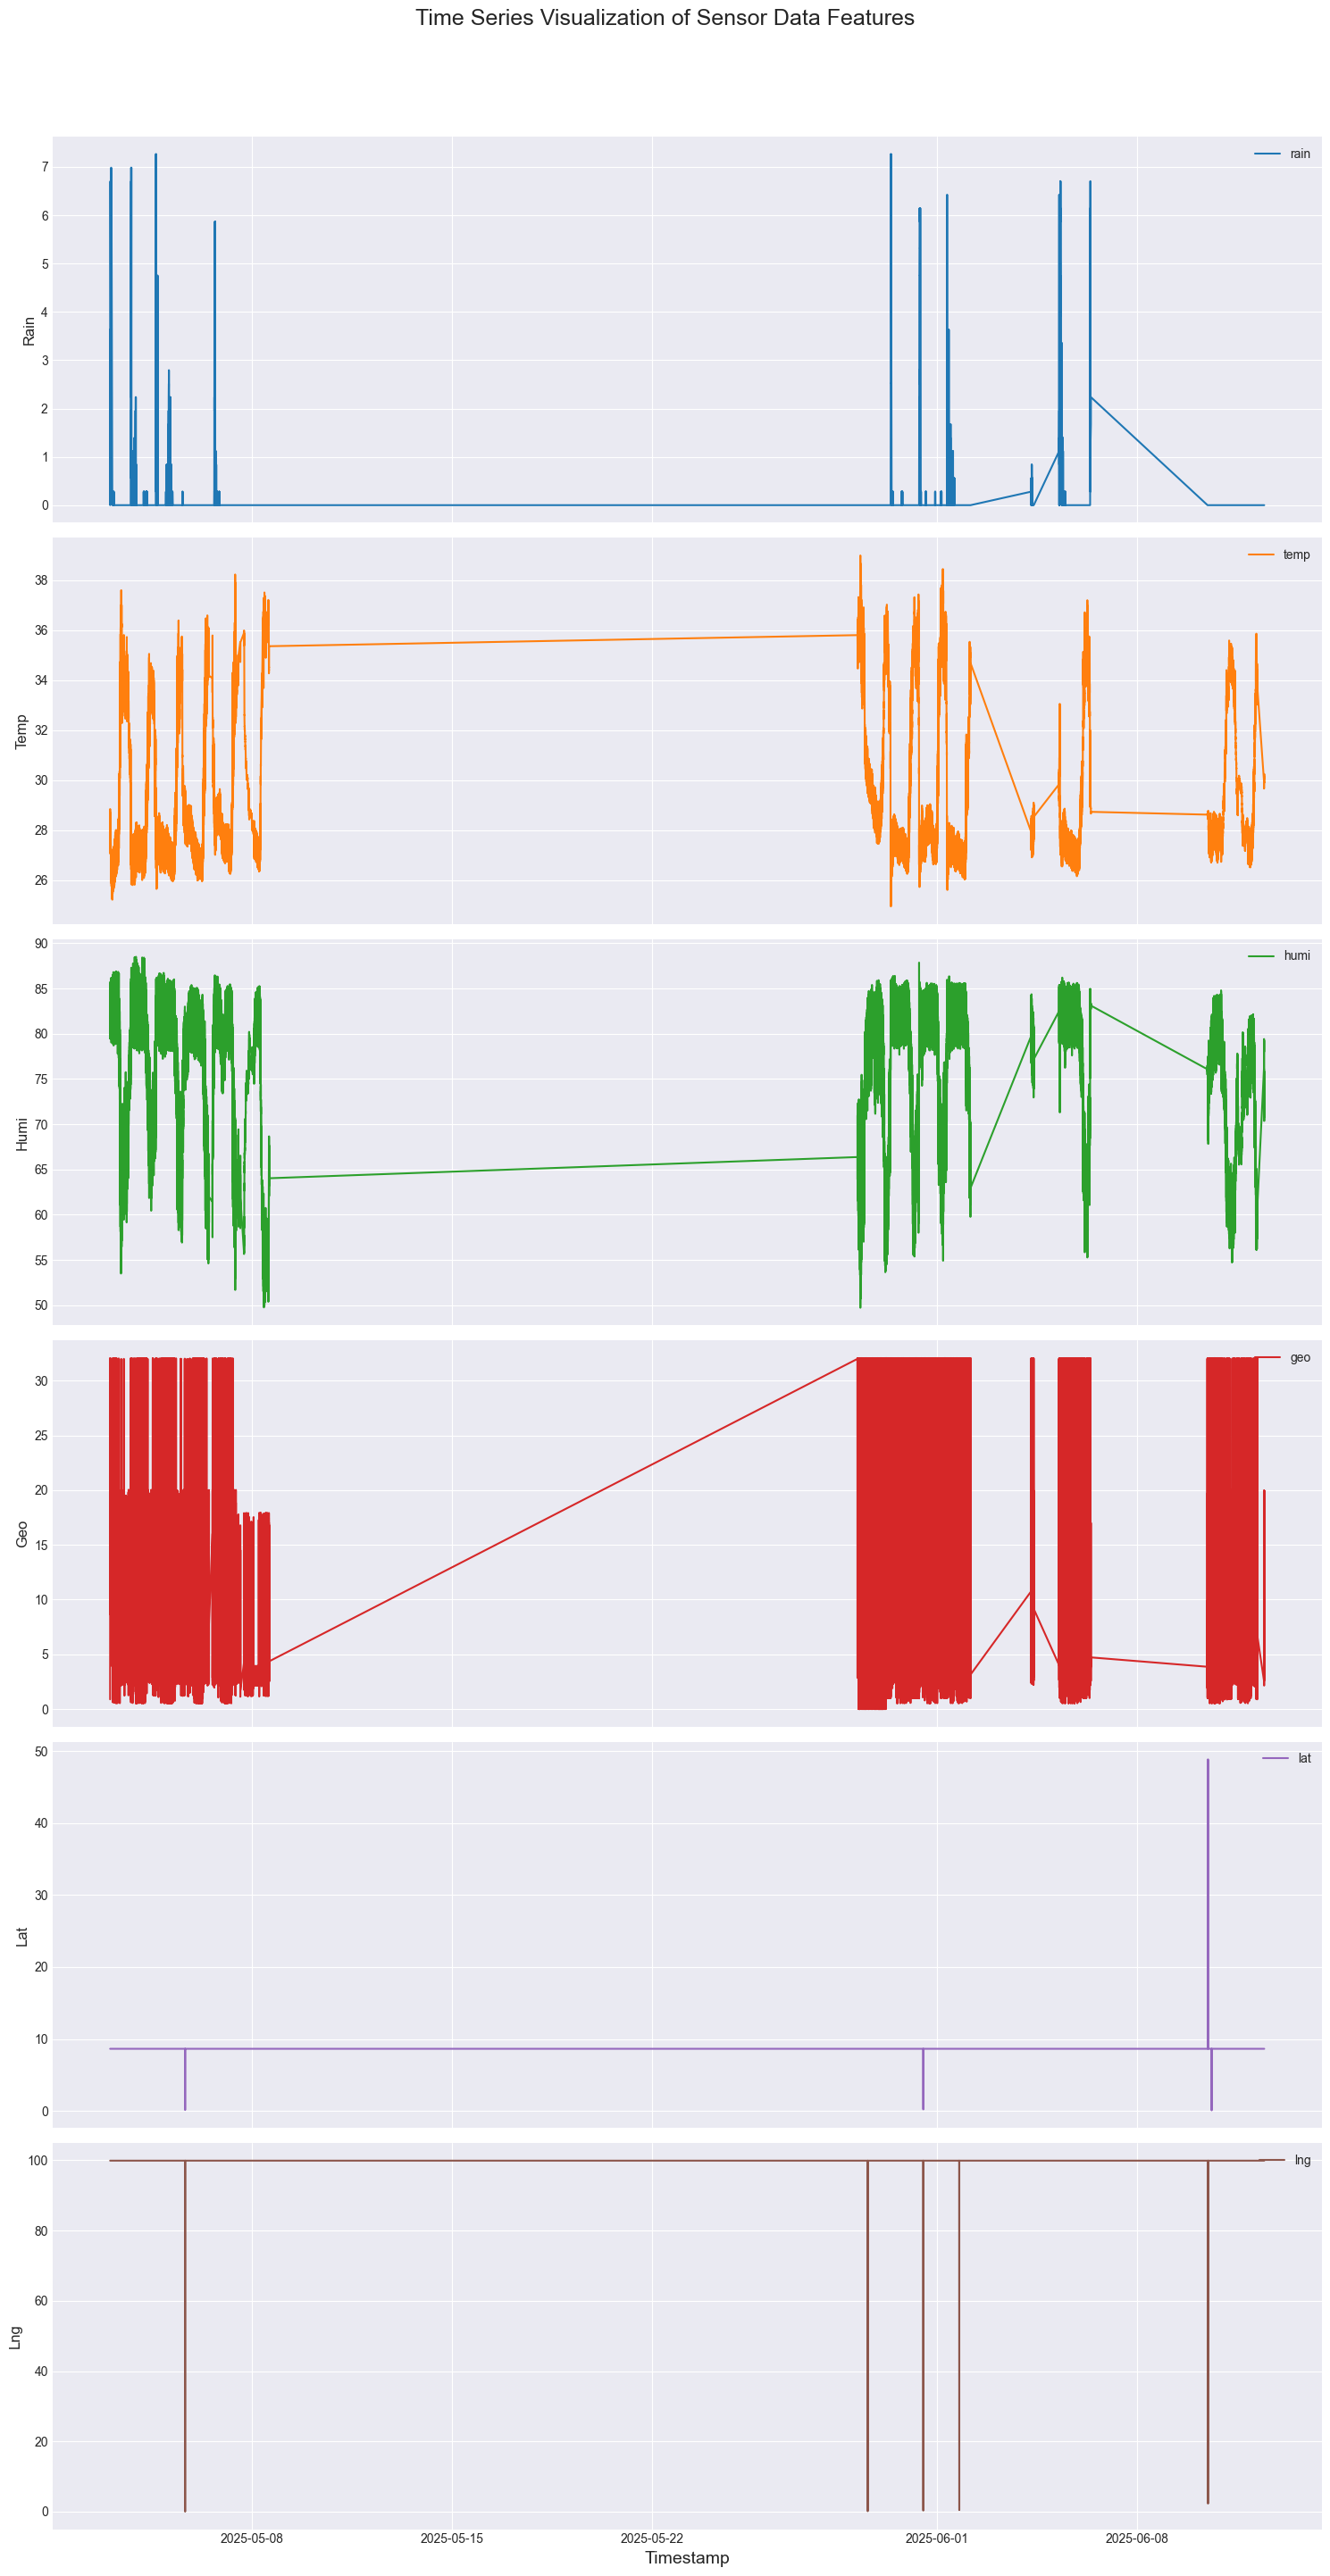

Visualization of 'rain', 'temp', 'humi', 'geo', 'lat', 'lng' complete.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # For potentially nicer plots, if available

# --- 1. Data Loading (as per your previous code) ---
# Define the paths to your CSV files
csv_file_path_1 = "../../data/dev101_prepared.csv"
csv_file_path_2 = "../../data/dev102_prepared.csv"

print(f"Loading data from: {csv_file_path_1} and {csv_file_path_2}\n")

try:
    df1 = pd.read_csv(csv_file_path_1)
    df2 = pd.read_csv(csv_file_path_2)
except FileNotFoundError as e:
    print(f"Error: One or more CSV files not found. Please check the paths.")
    print(f"Details: {e}")
    exit()

# Concatenate the dataframes
df_all = pd.concat([df1, df2], ignore_index=True)

# Convert 'timestamp' to datetime objects and sort the data
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
df_all = df_all.sort_values('timestamp').reset_index(drop=True)

print("Data loaded and prepared for visualization.\n")

# --- 2. Visualize Other Features ---

# Features to visualize (excluding 'timestamp' and 'soil' which was previously used)
features_to_visualize = ['rain', 'temp', 'humi', 'geo', 'lat', 'lng']

# Create separate plots for each feature for clarity
plt.style.use('seaborn-v0_8-darkgrid') # Optional: use a nice style

fig, axes = plt.subplots(len(features_to_visualize), 1, figsize=(15, 5 * len(features_to_visualize)), sharex=True)
fig.suptitle('Time Series Visualization of Sensor Data Features', y=0.99, fontsize=18)

for i, feature in enumerate(features_to_visualize):
    ax = axes[i] if len(features_to_visualize) > 1 else axes
    ax.plot(df_all['timestamp'], df_all[feature], label=feature, color=sns.color_palette("tab10")[i])
    ax.set_ylabel(feature.replace('_', ' ').title(), fontsize=12)
    ax.legend(loc='upper right')
    ax.grid(True)

# Set common x-axis label for the bottom plot
axes[-1].set_xlabel('Timestamp', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
plt.show()

print("Visualization of 'rain', 'temp', 'humi', 'geo', 'lat', 'lng' complete.")

# --- Optional: Pairplot for correlations (if you have fewer features or want to see relationships) ---
# If you have many data points, a pairplot can be very slow.
# Consider sampling or reducing features before running this.
# This might be useful for 'geo', 'lat', 'lng' to see if there are distinct clusters.

# print("\nGenerating Pairplot for numerical features (this might take a moment)...")
# numerical_feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo', 'lat', 'lng']
# sns.pairplot(df_all[numerical_feature_cols].sample(min(1000, len(df_all)))) # Sample for performance if data is large
# plt.suptitle('Pairplot of Numerical Features (Sampled)', y=1.02)
# plt.show()
# print("Pairplot generation complete.")

In [13]:
from tensorflow.keras.models import save_model
import joblib

# Save model
model.save('lstm_autoencoder_model.h5')
print("✅ Model saved as 'lstm_autoencoder_model.h5'")

# Save scaler
joblib.dump(scaler, 'scaler.save')
print("✅ Scaler saved as 'scaler.save'")


✅ Model saved as 'lstm_autoencoder_model.h5'
✅ Scaler saved as 'scaler.save'


In [ ]:
from tensorflow.keras.models import load_model
import joblib
import numpy as np

# Load model
model = load_model('lstm_autoencoder_model.h5')
print("✅ Model loaded successfully")

# Load scaler
scaler = joblib.load('scaler.save')
print("✅ Scaler loaded successfully")


In [ ]:
"""
def create_sequences(data, sequence_length):
    xs = []
    for i in range(len(data) - sequence_length + 1):
        xs.append(data[i:(i + sequence_length)])
    return np.array(xs)

# สมมติว่า new_raw_data คือข้อมูลใหม่ (array หรือ DataFrame)
# ตัวอย่าง dummy (ลบออกเมื่อใช้จริง):
# new_raw_data = df_new[['soil', 'rain', 'temp', 'humi', 'geo', 'lat', 'lng']].values

# Scale ข้อมูลใหม่
new_scaled_data = scaler.transform(new_raw_data)

# สร้าง sequence สำหรับ LSTM
SEQUENCE_LENGTH = 30  # ควรใช้ค่าเดียวกับตอนเทรน
new_seq_data = create_sequences(new_scaled_data, SEQUENCE_LENGTH)

# ทำนาย
predicted_seq = model.predict(new_seq_data)

# คำนวณ reconstruction error (Anomaly Score)
reconstruction_error = np.mean(np.mean(np.square(new_seq_data - predicted_seq), axis=1), axis=1)

# ตั้ง threshold ถ้าต้องการตรวจจับ anomaly
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

print(f"🔍 พบ {np.sum(anomalies)} anomalies จาก {len(anomalies)} sequences.")
"""